# Cars Price Prediction

### Piotr Baryczkowski

## Exploratory data analysis

Firstly we will categorize data types of attributes from Otomoto dataset, to correctly apply statistical measurements and conclude certain assumptions about it. In the next step we are going to analyse the distributions of attributes, look for errors and missing values. In the last step we will try to understand how certain attributes affect target price of vehicle e.g. is newer car more expensive than a slightly older car (vehicle_year attribute)?

#### Python libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn.metrics

#### Dataset overview

In [2]:
df = pd.read_csv(f"{os.getcwd()}/dataset/otomoto_price_prediction_data.csv")
df.head()

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,is_business,target_price
0,audi,a6,2013,153817.0,1984.0,180.0,automatic,petrol,0,0,69900.0
1,skoda,fabia,2004,115000.0,1390.0,75.0,manual,petrol,0,1,8299.0
2,chevrolet,camaro,2012,299000.0,3600.0,323.0,automatic,petrol,0,1,54500.0
3,bmw,seria-3,2013,155000.0,1995.0,163.0,automatic,diesel,0,0,62000.0
4,renault,talisman,2017,167000.0,1600.0,130.0,automatic,diesel,0,1,52999.0


In [3]:
NUM_RECORDS = df.shape[0] # used later to show how many records was dropped in preprocessing
df.shape

(206207, 11)

Dataset consists of 206207 samples, which are described with 10 attributes and the target price.

From statistical point of view, we can categorize our attributes into two types: categorical and numerical.
Make, model, gearbox and fuel_type are called nominal attributes and they belong to the first class. We have also binary attributes: damaged and is_business. 
Numerical class has 3 subclasses: discrete, interval and continuous. Mileage, engine_capacity and engine_power are continous attributes, because they have an infinite no. of states. Vehicle_year is a interval attribute.


The target price is categorized as a continuous type.

#### Looking for missing values and errors

Firstly we will make sure if there are some missing values in our dataset.

In [4]:
df.isna().sum()

make                  0
model                 0
vehicle_year          0
mileage            1354
engine_capacity    2178
engine_power       1579
gearbox            1365
fuel_type             0
damaged               0
is_business           0
target_price          0
dtype: int64

As we can see there is some lack of data in mileage, engine_capacity, engine_power and gearbox attribute. We will deal with this problem later in data preprocessing phase.

Now we will look for some errors.

In [5]:
df.describe()

,vehicle_year,mileage,engine_capacity,engine_power,damaged,is_business,target_price
count,206207.000000,2.048530e+05,204029.000000,204628.000000,206207.000000,206207.000000,2.062070e+05
mean,2012.313855,6.656787e+05,1865.096922,151.300301,0.038059,0.600038,6.273519e+04
std,6.453940,2.040768e+08,708.559717,76.915073,0.191339,0.489891,8.604596e+04
min,1917.000000,1.000000e+00,400.000000,1.000000,0.000000,0.000000,6.000000e+02
25%,2008.000000,4.500000e+04,1461.000000,105.000000,0.000000,0.000000,1.799900e+04
50%,2013.000000,1.378500e+05,1797.000000,136.000000,0.000000,1.000000,3.590000e+04
75%,2017.000000,1.990000e+05,1997.000000,170.000000,0.000000,1.000000,7.490000e+04
max,2021.000000,9.060612e+10,8400.000000,1500.000000,1.000000,1.000000,5.250000e+06


In the table above, we can find some interesting information e.g. minimal engine_power is 1 or maximum mileage which is 90 billions. To build the model correctly we will have to clear our data from that noise.

#### Target price distribution

1. The distribution is left skewed and of high variance
2. 75% of cars cost less than 74900 PLN
3. Maximum value of vehicle is 5250000 PLN, minimum is equal 600 PLN

I reckon, that these single cars with high prices can affect our model, so we have to consider that later.

In [6]:
df.target_price.describe()

count    2.062070e+05
mean     6.273519e+04
std      8.604596e+04
min      6.000000e+02
25%      1.799900e+04
50%      3.590000e+04
75%      7.490000e+04
max      5.250000e+06
Name: target_price, dtype: float64

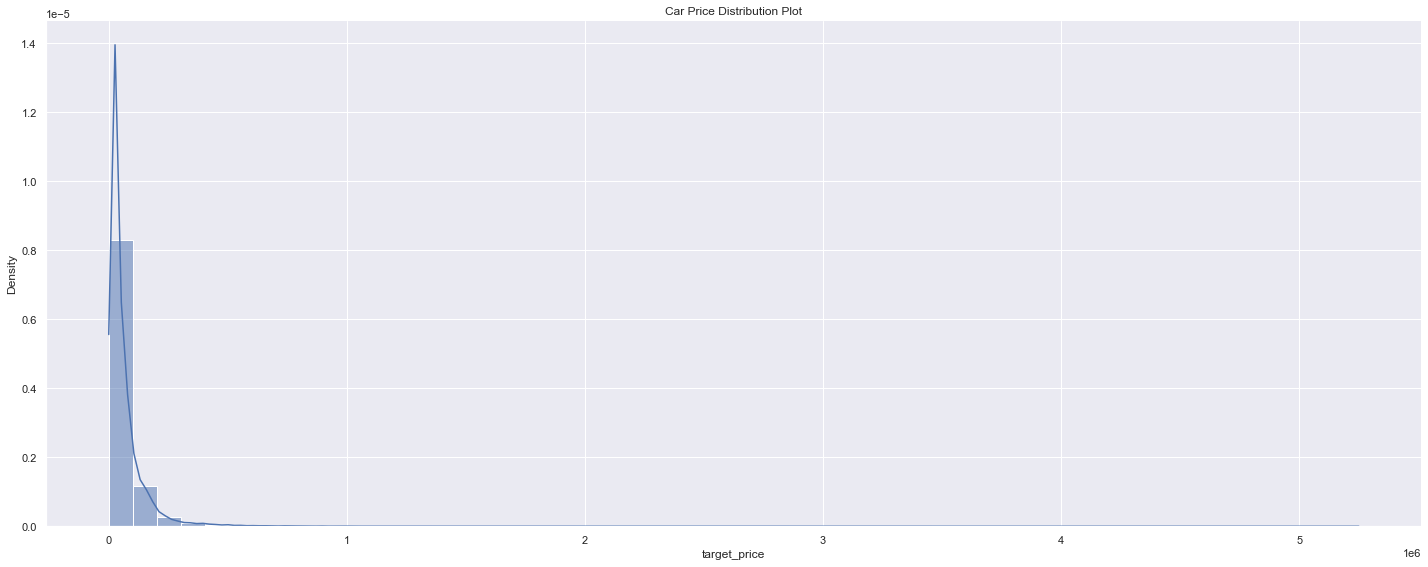

In [7]:
sns.set(rc= {"figure.figsize": (20,8)})

IQR = df.target_price.quantile(0.75) - df.target_price.quantile(0.25)
h = 2 * IQR * len(df.target_price)**(-1/3)
bins = (np.max(df.target_price) - np.min(df.target_price)) // h

sns.displot(data=df.target_price, stat="density", kde=True,
            bins=int(np.sqrt(bins)), height=8, aspect=20 / 8).set(title='Car Price Distribution Plot');

## Data preprocessing

### Dealing with missing data

As I mentioned before, we are going to deal with the missing data.

In [8]:
df[df.isnull().any(axis=1)].head(5)

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,is_business,target_price
143,mercedes-benz,gle,2020,NaN,2925.0,272.0,automatic,diesel,0,1,355400.0
243,audi,a5,2008,217000.0,NaN,NaN,NaN,diesel,0,0,35999.0
325,volkswagen,caddy,2020,NaN,1968.0,150.0,manual,diesel,0,1,129900.0
353,mini,clubman,2018,25500.0,NaN,NaN,NaN,petrol,0,0,84900.0
363,seat,leon,2008,128933.0,1600.0,102.0,NaN,petrol,0,0,17200.0


We are going to fill missing data in attributes (mileage, engine_capacity and engine_power) with the median values.


In [9]:
import warnings
warnings.filterwarnings('ignore')

df.fillna(df.median(), inplace=True)

There is still some missing data in gearbox attribute. We are going to fill it with values based on vehicle model. If there will still be some missing data, we are going to fill it with the most popular gearbox.

In [10]:
df[df.isnull().any(axis=1)]

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,is_business,target_price
243,audi,a5,2008,217000.0,1797.0,136.0,NaN,diesel,0,0,35999.0
353,mini,clubman,2018,25500.0,1797.0,136.0,NaN,petrol,0,0,84900.0
363,seat,leon,2008,128933.0,1600.0,102.0,NaN,petrol,0,0,17200.0
413,opel,zafira,2009,189000.0,1800.0,140.0,NaN,petrol,0,1,18500.0
473,mazda,6,2014,62000.0,1797.0,136.0,NaN,petrol,0,0,45500.0
...,...,...,...,...,...,...,...,...,...,...,...
205664,bmw,seria-3,2004,215111.0,1797.0,136.0,NaN,petrol,0,0,8700.0
205772,kia,ceed,2018,86450.0,1400.0,100.0,NaN,petrol,0,1,49190.0
205797,opel,insignia,2009,183500.0,1999.0,220.0,NaN,petrol,0,0,37000.0
206040,ford,fusion,2006,257000.0,1400.0,136.0,NaN,diesel,1,1,3900.0


In [11]:
def get_gearbox_type(row):
    mode = df[(df.make == row['make']) & (df.model == row['model'])]['gearbox'].mode()
    if mode.empty:
        return np.nan
    return mode[0]

In [12]:
df.gearbox = df.apply(lambda row: get_gearbox_type(row) if row['gearbox'] == np.nan else row['gearbox'], axis=1)

In [13]:
df[df.isnull().any(axis=1)]

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,is_business,target_price
243,audi,a5,2008,217000.0,1797.0,136.0,NaN,diesel,0,0,35999.0
353,mini,clubman,2018,25500.0,1797.0,136.0,NaN,petrol,0,0,84900.0
363,seat,leon,2008,128933.0,1600.0,102.0,NaN,petrol,0,0,17200.0
413,opel,zafira,2009,189000.0,1800.0,140.0,NaN,petrol,0,1,18500.0
473,mazda,6,2014,62000.0,1797.0,136.0,NaN,petrol,0,0,45500.0
...,...,...,...,...,...,...,...,...,...,...,...
205664,bmw,seria-3,2004,215111.0,1797.0,136.0,NaN,petrol,0,0,8700.0
205772,kia,ceed,2018,86450.0,1400.0,100.0,NaN,petrol,0,1,49190.0
205797,opel,insignia,2009,183500.0,1999.0,220.0,NaN,petrol,0,0,37000.0
206040,ford,fusion,2006,257000.0,1400.0,136.0,NaN,diesel,1,1,3900.0


In [14]:
# Fill the rest with mode
df['gearbox'].fillna(df['gearbox'].mode().max(), inplace=True)

In [15]:
df[df.isnull().any(axis=1)]

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,is_business,target_price


### Dealing with categorical attributes

Our dataset consists of both numeric and categorical attributes. We have to transform our categorical attributes into numeric values, because our model need to understand them as inputs. That is why we are going to use one-hot encoding to transform the categorical attributes.

In [16]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(df[['make', 'model', 'gearbox', 'fuel_type']]).toarray())

df = df.join(encoder_df)

df.drop(['make', 'model', 'gearbox', 'fuel_type'], axis=1, inplace=True)

In [17]:
price_df = pd.DataFrame(df.target_price)

df.drop(['target_price'], axis=1, inplace=True)

df = df.join(price_df)

### Dealing with unreliable data

In my car I have a seven-digit counter, where last digit is for hundreds of meters, so I assume, that maximum reliable mileage is 999999. An average car user travels up to 1000 miles a month, so it gives 12000 miles a year. We can find lots of company cars on the market so reliable mileage per year will be higher. In my opinion 65000 is an upper limit for this attribute.

Sources:
[https://heycar.co.uk/guides/what-is-high-mileage](https://heycar.co.uk/guides/what-is-high-mileage)
[How much horsepower constitutes as enough for a car?](https://www.quora.com/How-much-horsepower-constitutes-as-enough-for-a-car)
[https://carbiketech.com/engine-capacity-cc/](https://carbiketech.com/engine-capacity-cc/)

In [18]:
import datetime
current_year = datetime.datetime.now().year

MAXIMUM_RELIABLE_MILEAGE = 10**6 - 1
MAXIMUM_RELIABLE_MILEAGE_PER_YEAR = 65 * 10**3
MINIMUM_HORSEPOWER = 48 # The VW Rabbit MK1 Diesels of the late 1970’s had a whopping 48HP
MAXIMUM_ENGINE_CAPACITY = 5000

df.drop(df[df.mileage > MAXIMUM_RELIABLE_MILEAGE].index, inplace=True)
df.drop(df[df.mileage / (current_year - df.vehicle_year + 1) > MAXIMUM_RELIABLE_MILEAGE_PER_YEAR].index, inplace=True)
df.drop(df[df.engine_capacity > MAXIMUM_ENGINE_CAPACITY].index, inplace=True)
df.drop(df[df.engine_power < MINIMUM_HORSEPOWER].index, inplace=True)

print(f"Dropped {NUM_RECORDS - df.shape[0]} records.")

Dropped 2296 records.


Now that our dataset is over the preprocessing phase, we are ready to create our models.

## Building model

We will start with splitting our dataset into variables and targets. Then, we will split data into training and test sets.

In [19]:
from sklearn.model_selection import train_test_split

x = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In this challenge we will try two different models:

1. Decision Tree Regressor
2. Random Forest Regressor
3. Gradient Booster Regressor

### Metrics

Metrics are necessary to compare and later choose our final regression model. In my opinion using more than one metrics paints bigger picture of how our model is performing. For this challenge I chose 3 metrics:

- Mean Absolute Error (MAE) - takes it easy on our model compared to RMSE.
- Root Mean Square Error (RMSE) - punishes our model when it makes big mistakes.
- Coefficient Of Determination (R2) - tells us what part of data it "explains".

The goal for us is to create and pick model with the lowest MAE and RMSE and the highest R2.

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def show_metrics(true: np.array, pred: np.array) -> None:
    print(f"MAE: {mean_absolute_error(true, pred):.4f}\n"
          f"RMSE: {np.sqrt(mean_squared_error(true, pred)):.4f}\n"
          f"R2: {r2_score(true, pred):.4f}")

def plot_compare_true_pred(true: np.array, pred:np.array) -> None:
    df = pd.DataFrame({'true_values': true, 'predicted_values': pred})
    sns.scatterplot(data=df).set(title='Predicted values vs. True values')

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

METRICS = {
    'MAE': make_scorer(mean_absolute_error), 
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'R2': make_scorer(r2_score)
}

PARAMS = {
    'max_depth': (3, 6, 9),
    'n_estimators': (5, 10, 15)
}

def test_model(x, y, model, parameters=PARAMS, scoring=METRICS):
    gs = GridSearchCV(model, parameters, scoring=scoring, cv=5, refit='R2', verbose=2)
    gs.fit(x, y)
    
    return gs.cv_results_

### Decision Tree Regressor

Our MAE is 8725.6 PLN and our RMSE is 26251.73 PLN which is more than 3 times higher. This means, that our model did not perform very well when it comes to expensive vehicles. On the other hand, R2 score is quiet good (it "explains" 89.23% of our data).

In [38]:
from sklearn.tree import DecisionTreeRegressor

dt_regressor = DecisionTreeRegressor(max_depth=25, random_state=0)
dt_regressor.fit(x_train, y_train)
y_pred = dt_regressor.predict(x_test)

show_metrics(y_test, y_pred)

MAE: 8725.6603
RMSE: 26251.7323
R2: 0.8923


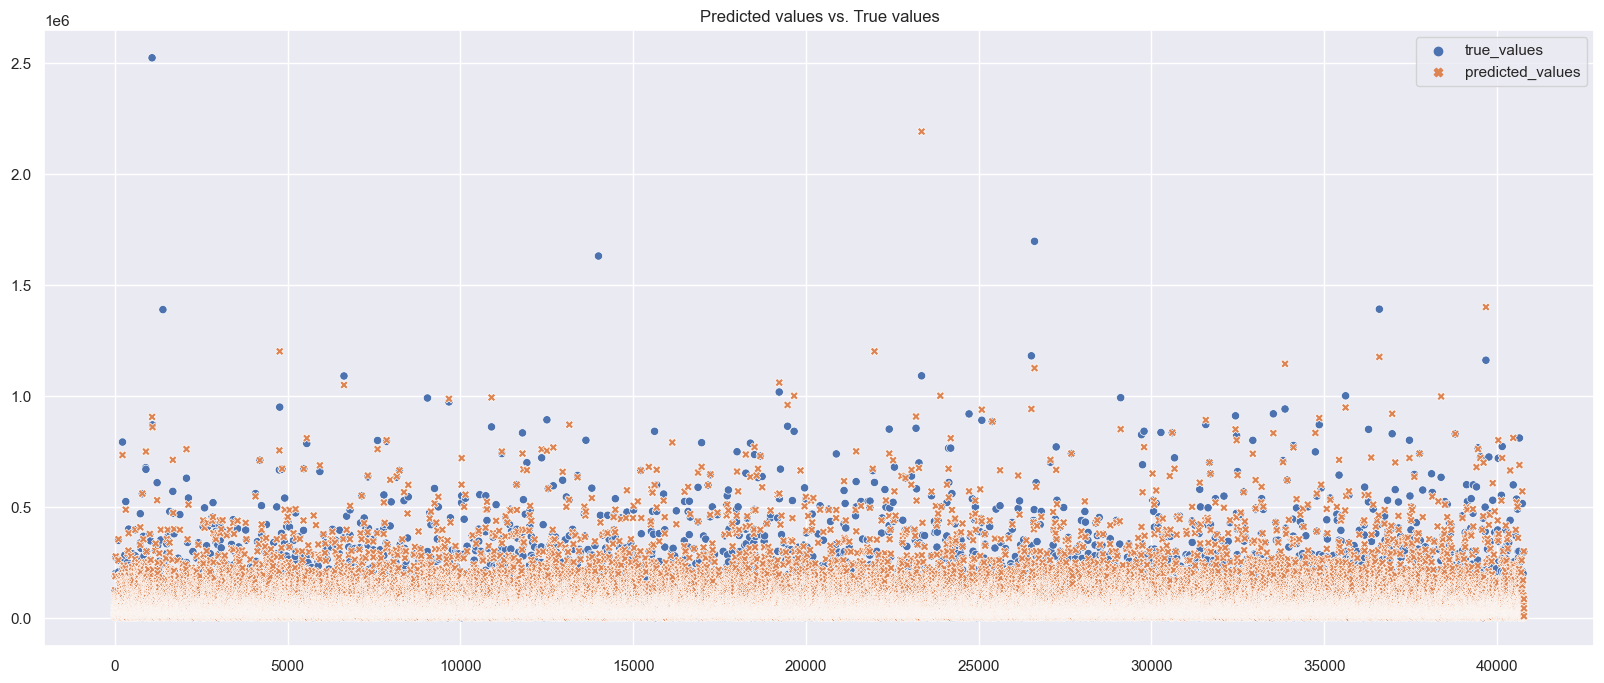

In [40]:
plot_compare_true_pred(y_test, y_pred)

Now let's see how our metrics change with different parameters. For this experiment, we will use Grid Search.

In [41]:
results = test_model(x_train, y_train, DecisionTreeRegressor(), {'max_depth': (3, 6, 9)}, METRICS)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


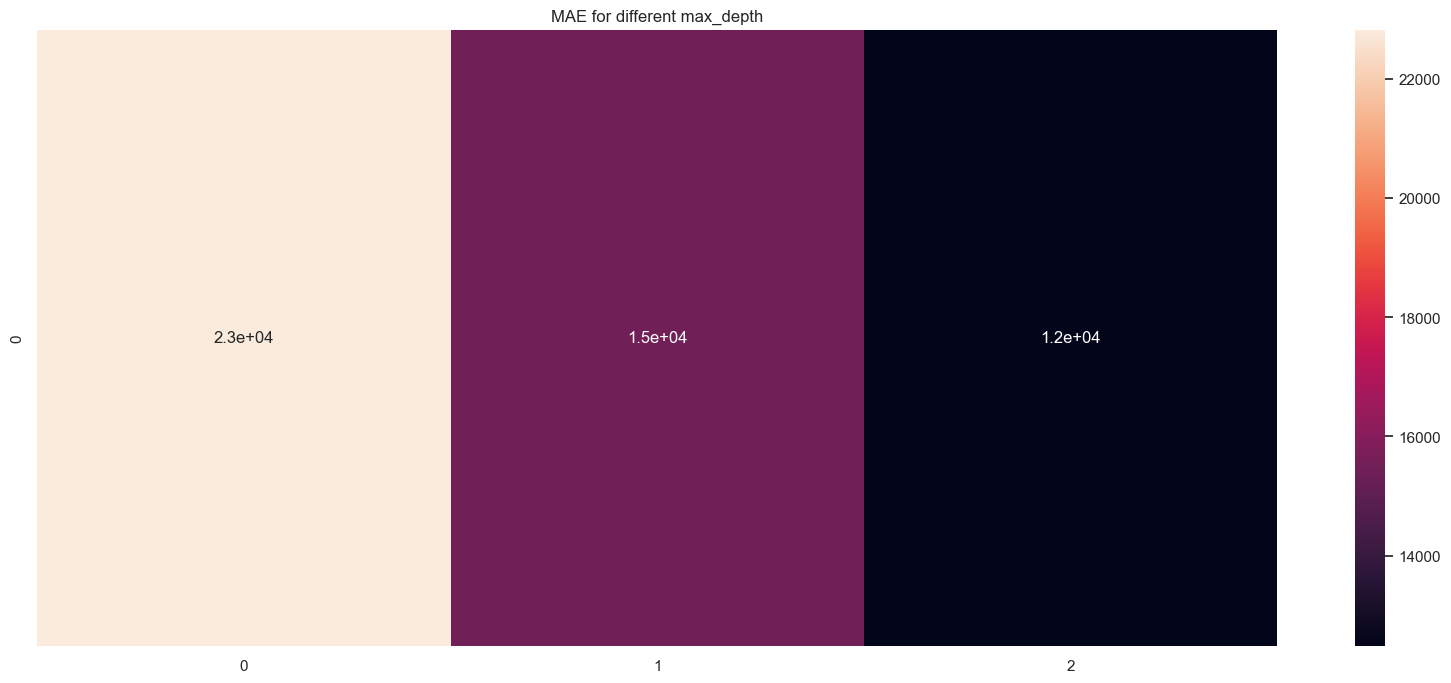

In [43]:
sns.heatmap([results['mean_test_MAE']], annot=True).set(title='MAE for different max_depth');

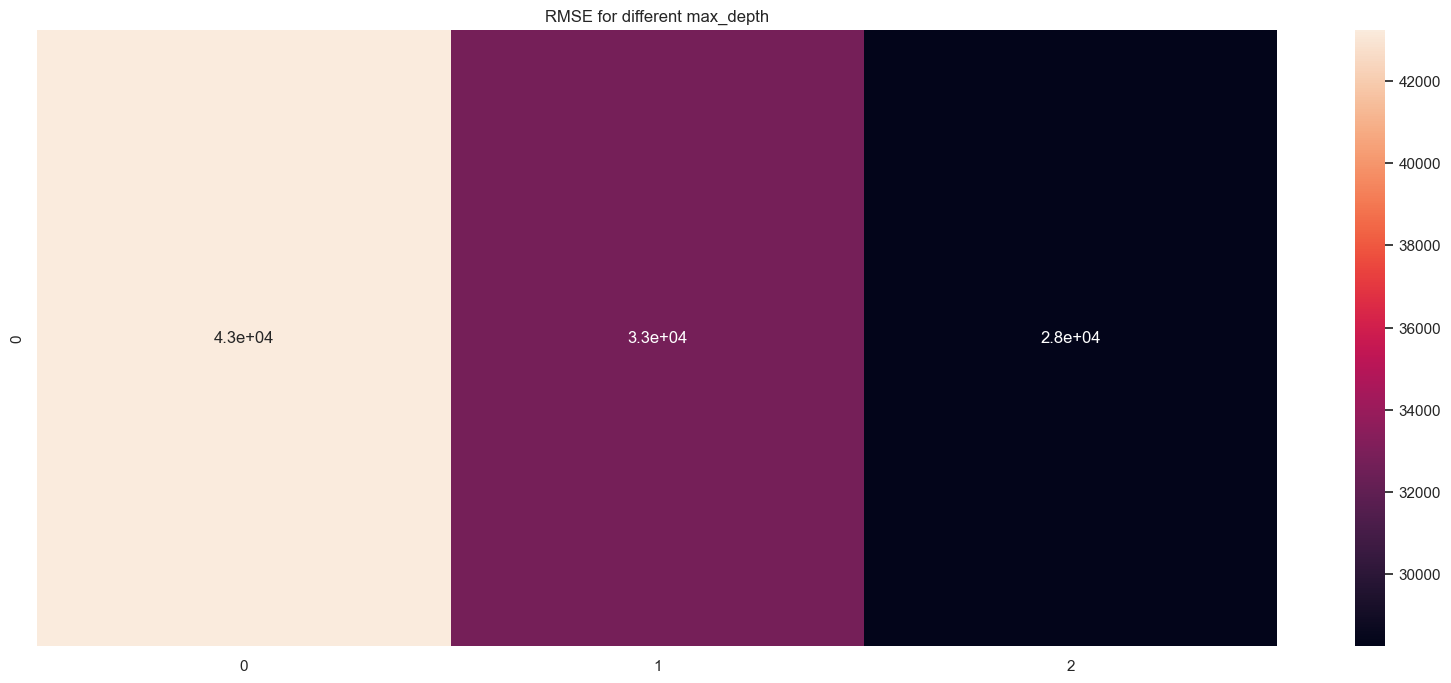

In [44]:
sns.heatmap([results['mean_test_RMSE']], annot=True).set(title='RMSE for different max_depth');

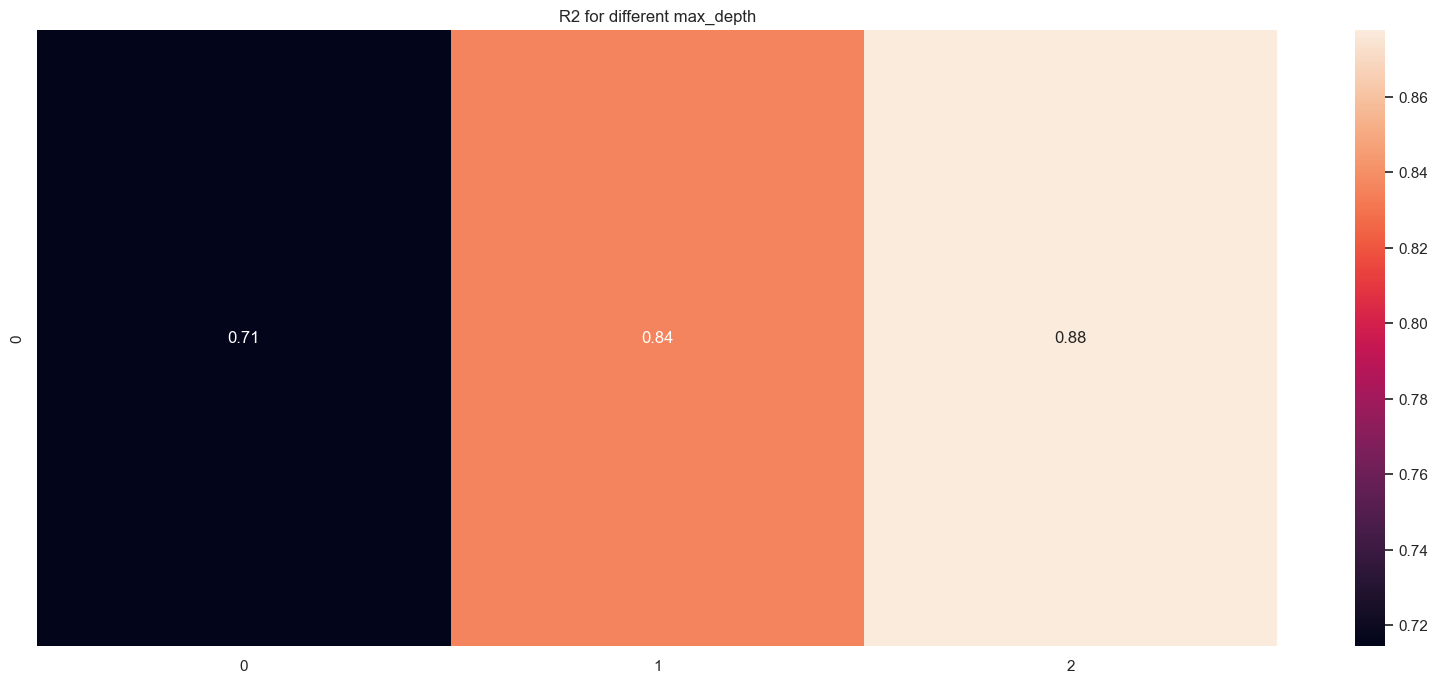

In [45]:
sns.heatmap([results['mean_test_R2']], annot=True).set(title='R2 for different max_depth');

### Random Forest Regressor

As we excepted, Random Forest Regressor preformed better than Decision Tree Regressor (in case of metrics). MAE score is 7449.07 PLN and RMSE is 21668.6617 PLN. R2 score is also increased to 92.66%.

In [28]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(max_depth=25, n_estimators=25, random_state=0)
rf_regressor.fit(x_train, y_train)
y_pred = rf_regressor.predict(x_test)

show_metrics(y_test, y_pred)

MAE: 7449.0747
RMSE: 21668.6617
R2: 0.9266


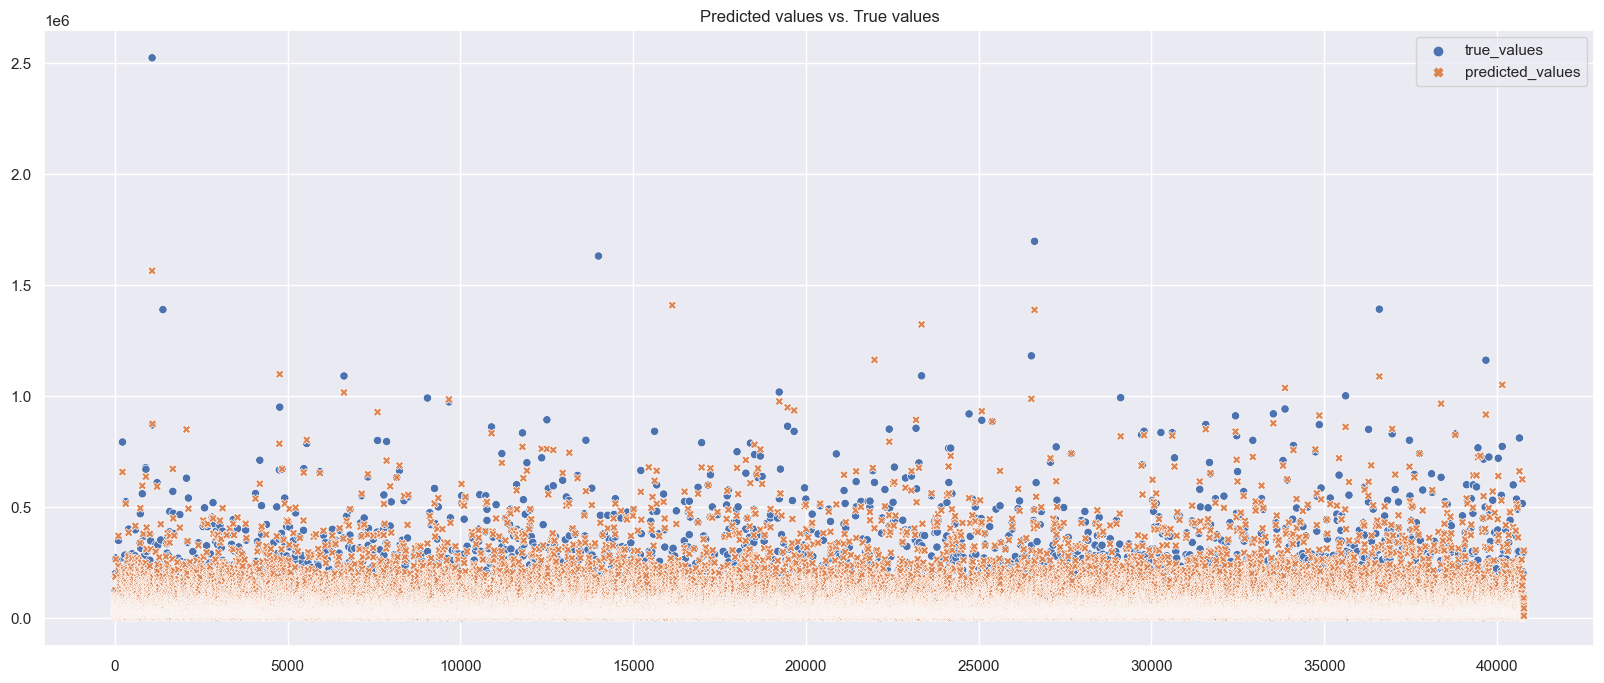

In [29]:
plot_compare_true_pred(y_test, y_pred)

In [46]:
results = test_model(x_train, y_train, RandomForestRegressor(), PARAMS, METRICS)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ........................max_depth=3, n_estimators=5; total time=  14.0s
[CV] END ........................max_depth=3, n_estimators=5; total time=  14.0s
[CV] END ........................max_depth=3, n_estimators=5; total time=  13.8s
[CV] END ........................max_depth=3, n_estimators=5; total time=  14.1s
[CV] END ........................max_depth=3, n_estimators=5; total time=  14.7s
[CV] END .......................max_depth=3, n_estimators=10; total time=  27.4s
[CV] END .......................max_depth=3, n_estimators=10; total time=  27.2s
[CV] END .......................max_depth=3, n_estimators=10; total time=  27.0s
[CV] END .......................max_depth=3, n_estimators=10; total time=  27.2s
[CV] END .......................max_depth=3, n_estimators=10; total time=  27.3s
[CV] END .......................max_depth=3, n_estimators=15; total time=  41.5s
[CV] END .......................max_depth=3, n_es

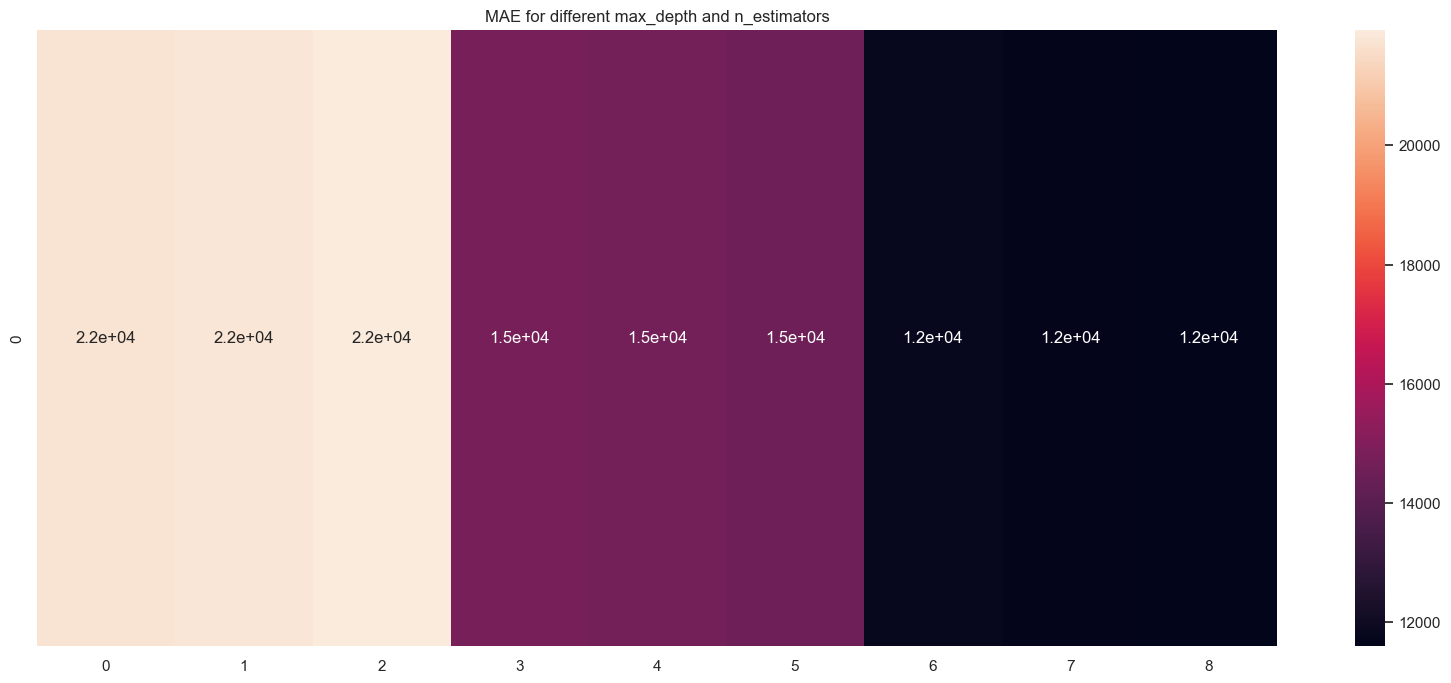

In [52]:
sns.heatmap([results['mean_test_MAE']], annot=True).set(title='MAE for different max_depth and n_estimators');

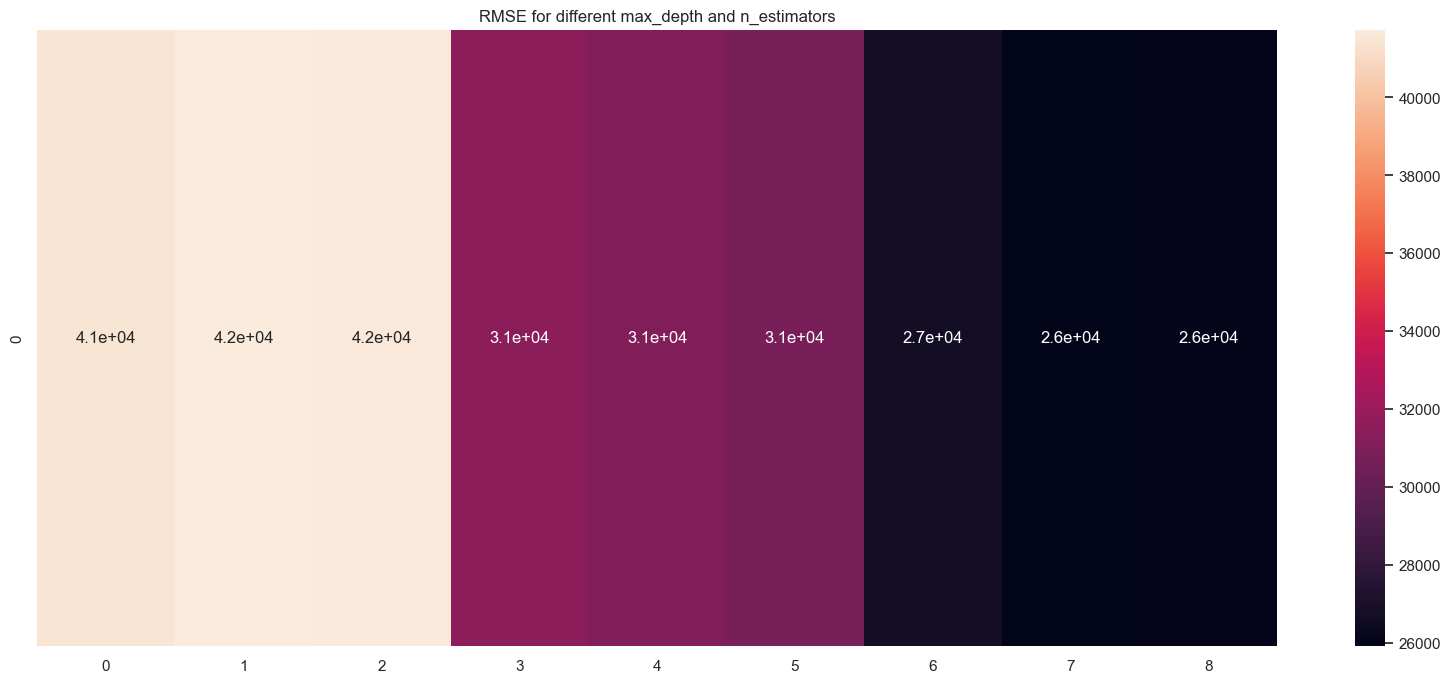

In [53]:
sns.heatmap([results['mean_test_RMSE']], annot=True).set(title='RMSE for different max_depth and n_estimators');

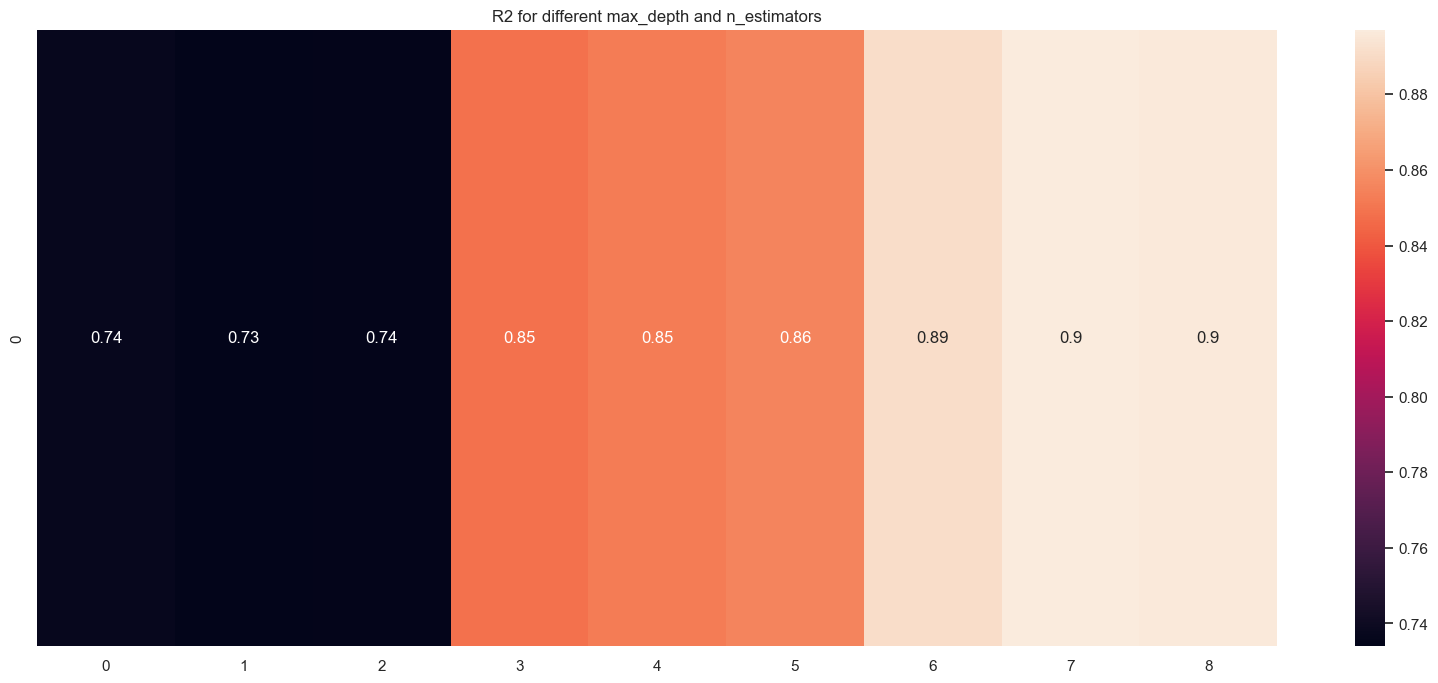

In [54]:
sns.heatmap([results['mean_test_R2']], annot=True).set(title='R2 for different max_depth and n_estimators');

### Gradient Boosting Regressor

Gradient Boosting Regressor gave us promissing results. This model has to be tested on different max_depth and number of estimators. I reckon that, then it will perform better. MAE is 8636.28 PLN, RMSE is 23137.45 PLN and R2 is 91.63%.

In [55]:
from sklearn.ensemble import GradientBoostingRegressor

gb_regressor = GradientBoostingRegressor(max_depth=25, n_estimators=25, verbose=1)
gb_regressor.fit(x_train, y_train)
y_pred = gb_regressor.predict(x_test)

show_metrics(y_test, y_pred)

      Iter       Train Loss   Remaining Time 
         1  5317786543.8267            4.90m
         2  4318067770.5211            4.76m
         3  3507896085.5635            4.58m
         4  2851272395.6552            4.35m
         5  2318794793.4373            4.14m
         6  1887053253.8445            3.91m
         7  1537035593.6354            3.69m
         8  1253094431.4211            3.47m
         9  1022634724.1618            3.26m
        10   836009930.5167            3.05m
        20   130249766.5593            1.01m
MAE: 8636.2817
RMSE: 23137.4509
R2: 0.9163


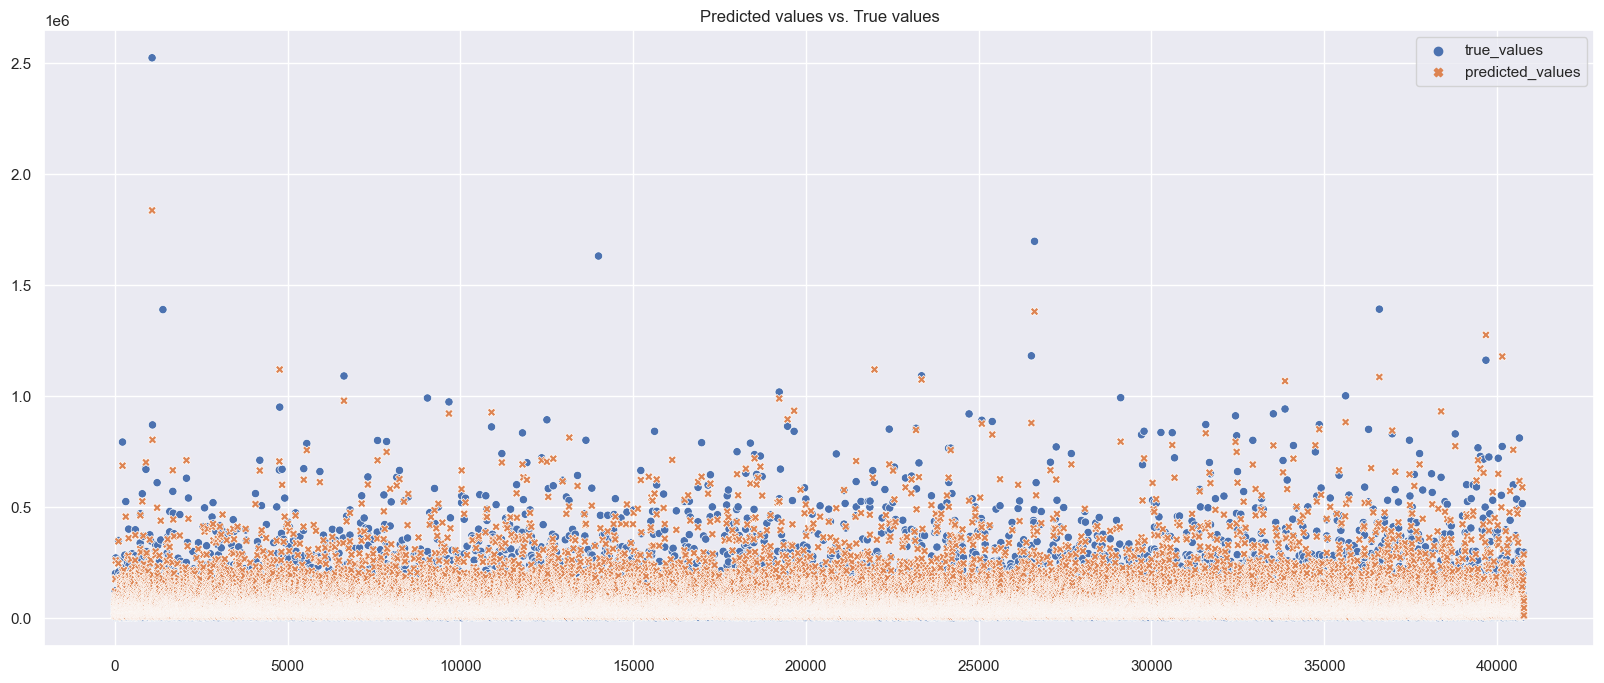

In [56]:
plot_compare_true_pred(y_test, y_pred)

In [57]:
results = test_model(x_train, y_train, GradientBoostingRegressor(), PARAMS, METRICS)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ........................max_depth=3, n_estimators=5; total time=  24.6s
[CV] END ........................max_depth=3, n_estimators=5; total time=  24.7s
[CV] END ........................max_depth=3, n_estimators=5; total time=  24.0s
[CV] END ........................max_depth=3, n_estimators=5; total time=  25.1s
[CV] END ........................max_depth=3, n_estimators=5; total time=  23.7s
[CV] END .......................max_depth=3, n_estimators=10; total time=  46.4s
[CV] END .......................max_depth=3, n_estimators=10; total time=  46.4s
[CV] END .......................max_depth=3, n_estimators=10; total time=  46.7s
[CV] END .......................max_depth=3, n_estimators=10; total time=  46.4s
[CV] END .......................max_depth=3, n_estimators=10; total time=  46.1s
[CV] END .......................max_depth=3, n_estimators=15; total time= 1.2min
[CV] END .......................max_depth=3, n_es

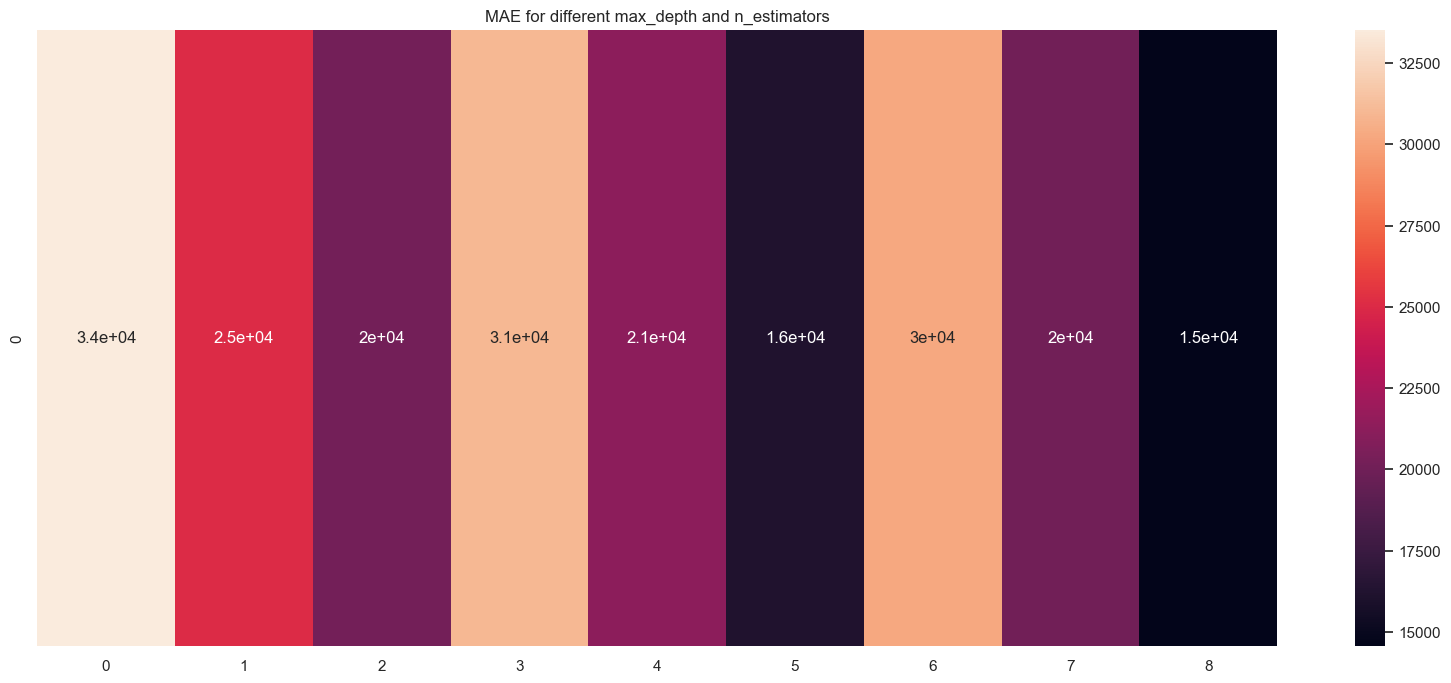

In [58]:
sns.heatmap([results['mean_test_MAE']], annot=True).set(title='MAE for different max_depth and n_estimators');

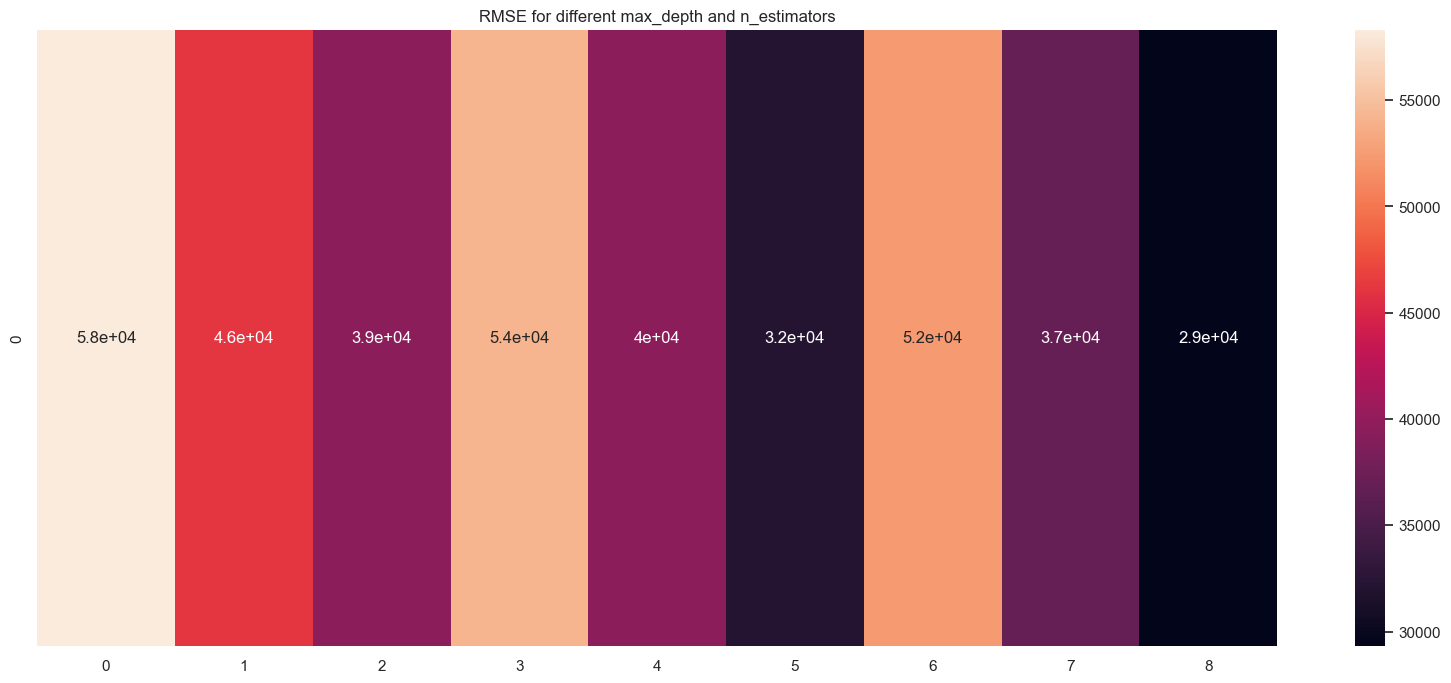

In [59]:
sns.heatmap([results['mean_test_RMSE']], annot=True).set(title='RMSE for different max_depth and n_estimators');

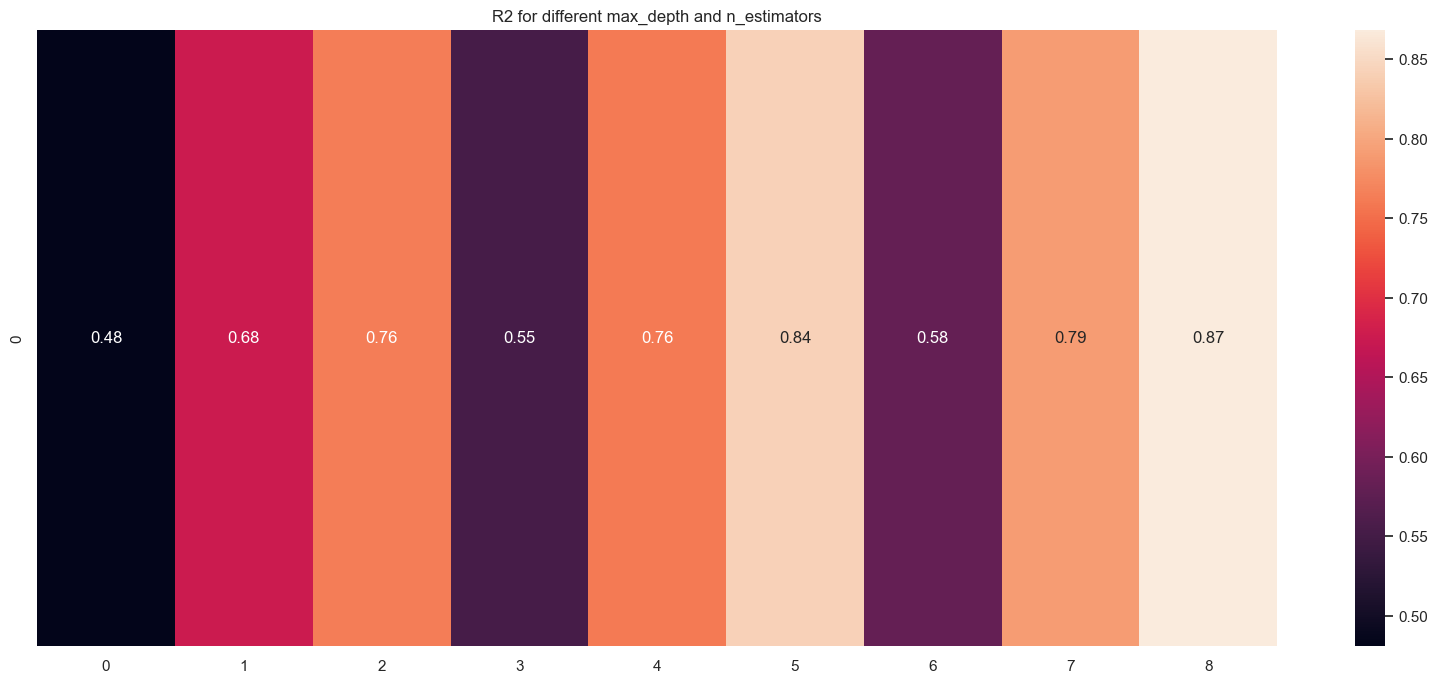

In [60]:
sns.heatmap([results['mean_test_R2']], annot=True).set(title='R2 for different max_depth and n_estimators');

### Summary

The best regression model had a MAE of 7449.07 PLN, RMSE of 21668.6617 PLN and R2 of 92.66%. The errors might be caused by poorer precision of prediction for expensive cars. Further, actions listed below would result in better model performance.

#### Further actions

1. Definitely try out other regression models e.g. ridge regressor or SVM regressor.
2. Spend more time on visualization, it may help me with better understanding the problem. There was too little time to get a proper look on dataset.
3. Spend more time on the reliability of the dataset - try out other methods of filling NaNs, find and drop more outliers, that I might have missed.
4. Plot more information about model performance, find different metrics, that might be better for this problem.


Thank you for reading this notebook,
Piotr Baryczkowski